# Titanic Dataset Train

-----

### Import Cell

In [1]:
# !pip install --upgrade xgboost
# help(xgb.XGBClassifier.fit)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import sys
import string
import numpy as np
import matplotlib.pyplot as plt


import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split,learning_curve,validation_curve,GridSearchCV,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,roc_auc_score,classification_report,log_loss,mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

import seaborn as sns
from typing import Tuple

### Checking versions

In [3]:
print("Python - " + str(sys.version) )
print("Pandas - " + str(pd.__version__))
print("SKLearn - " + str(sklearn.__version__))
print("XGB - " + xgb.__version__)

Python - 3.13.2 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:14) [MSC v.1929 64 bit (AMD64)]
Pandas - 2.2.3
SKLearn - 1.6.1
XGB - 3.0.0


### Import training Dataset

In [4]:
df = pd.read_csv('Datasets/train.csv')
print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


## Exploratory Data Analysis

### Histograms for Numerical Features

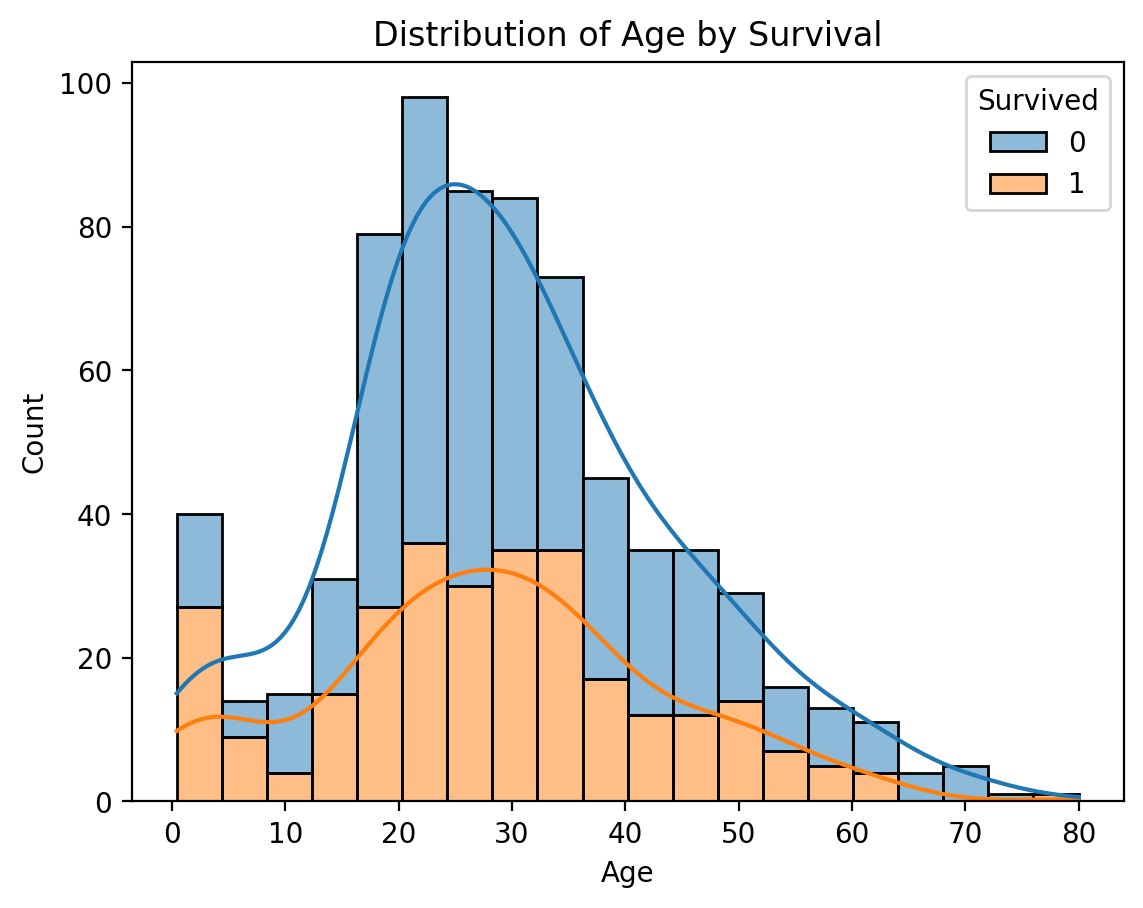

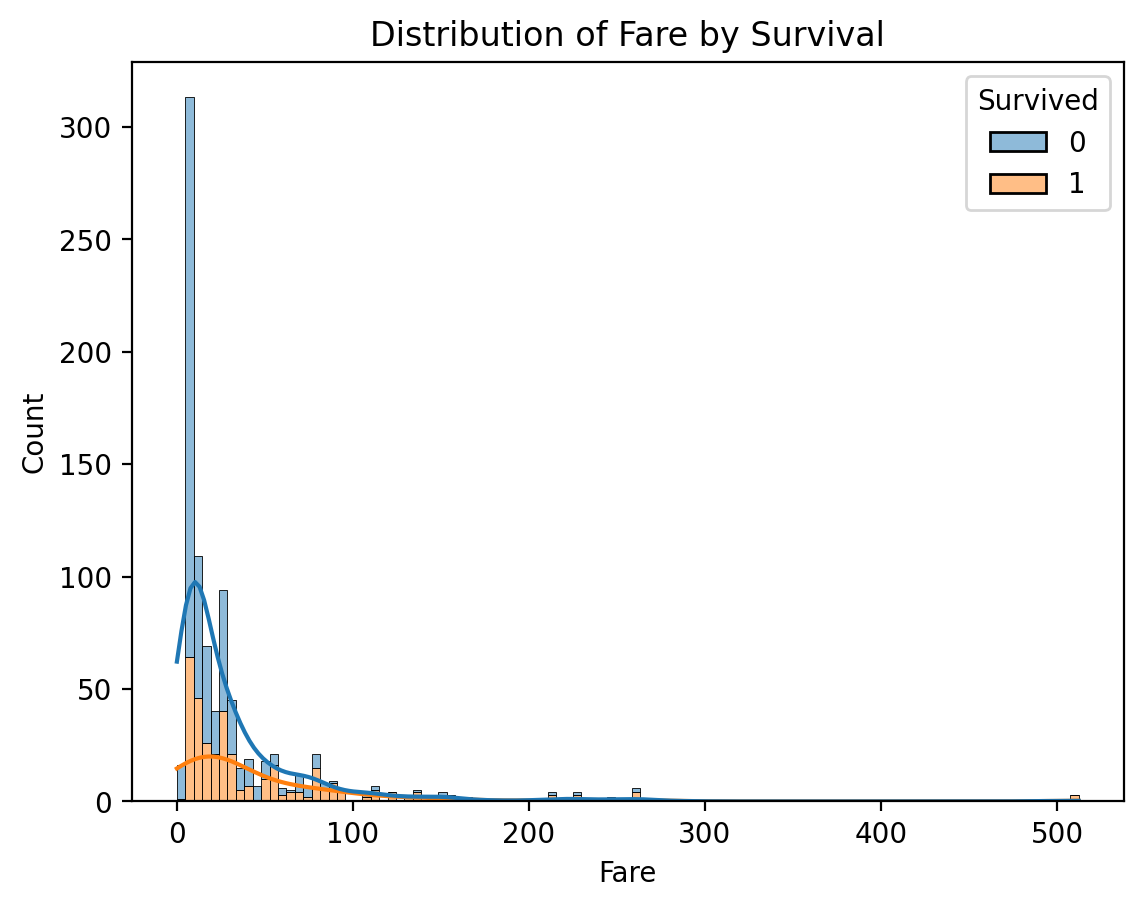

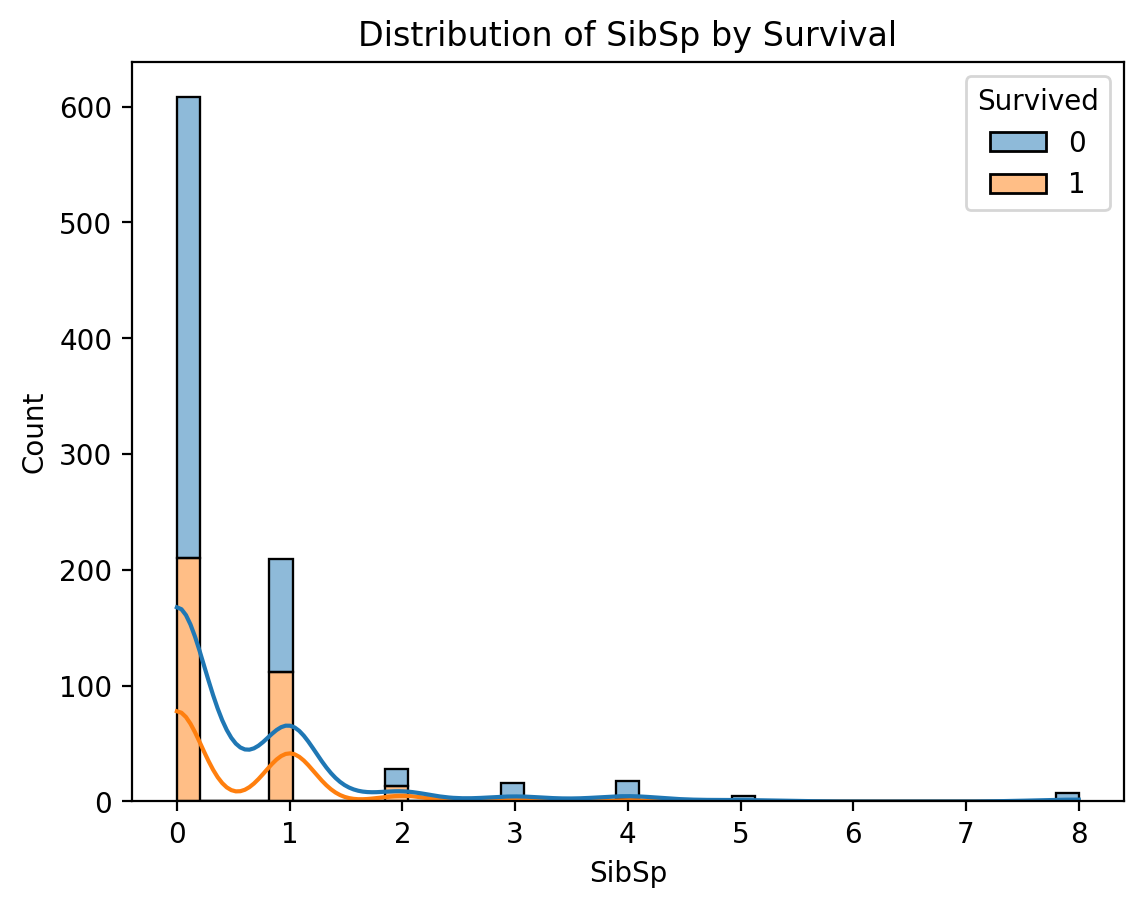

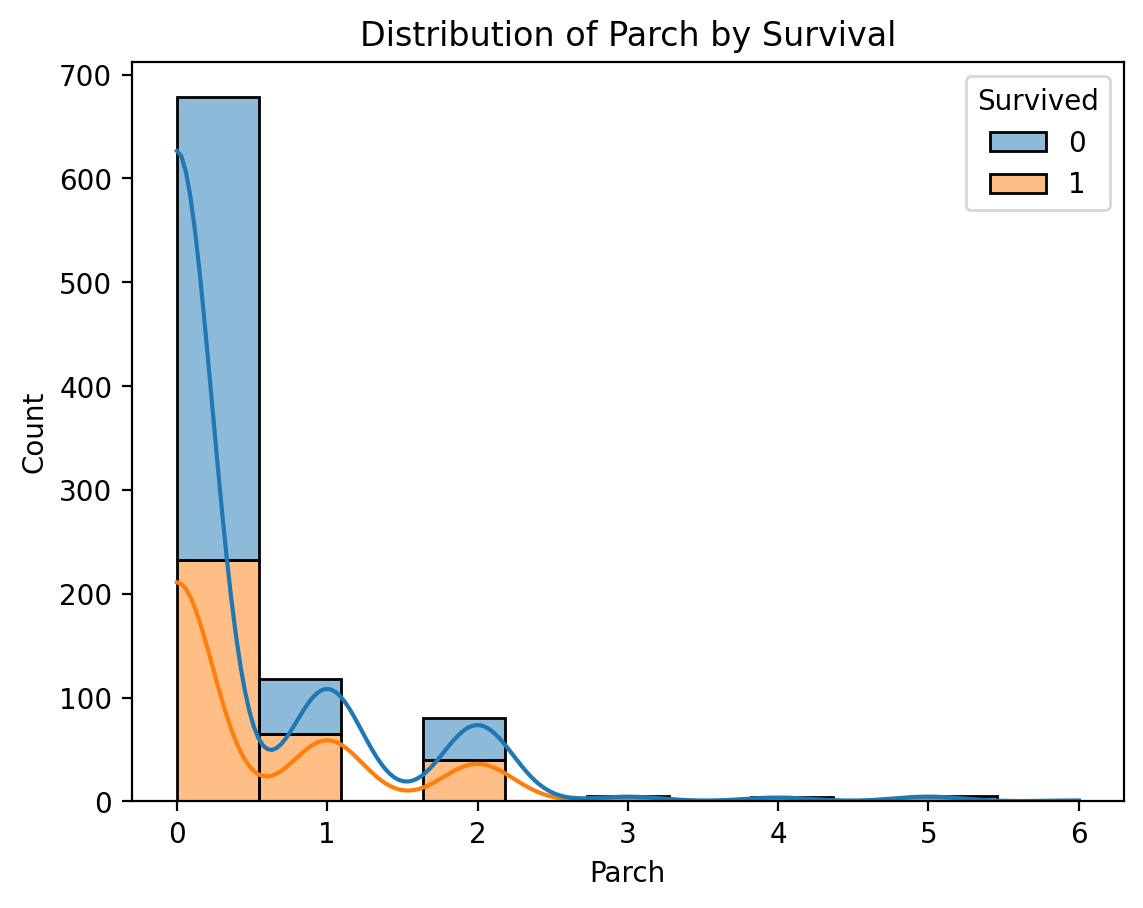

In [5]:
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']
for feature in numerical_features:
    sns.histplot(data=df, x=feature, hue='Survived', multiple='stack', kde=True)
    plt.title(f'Distribution of {feature} by Survival')
    plt.show()

### Bar Plots for Categorical Features

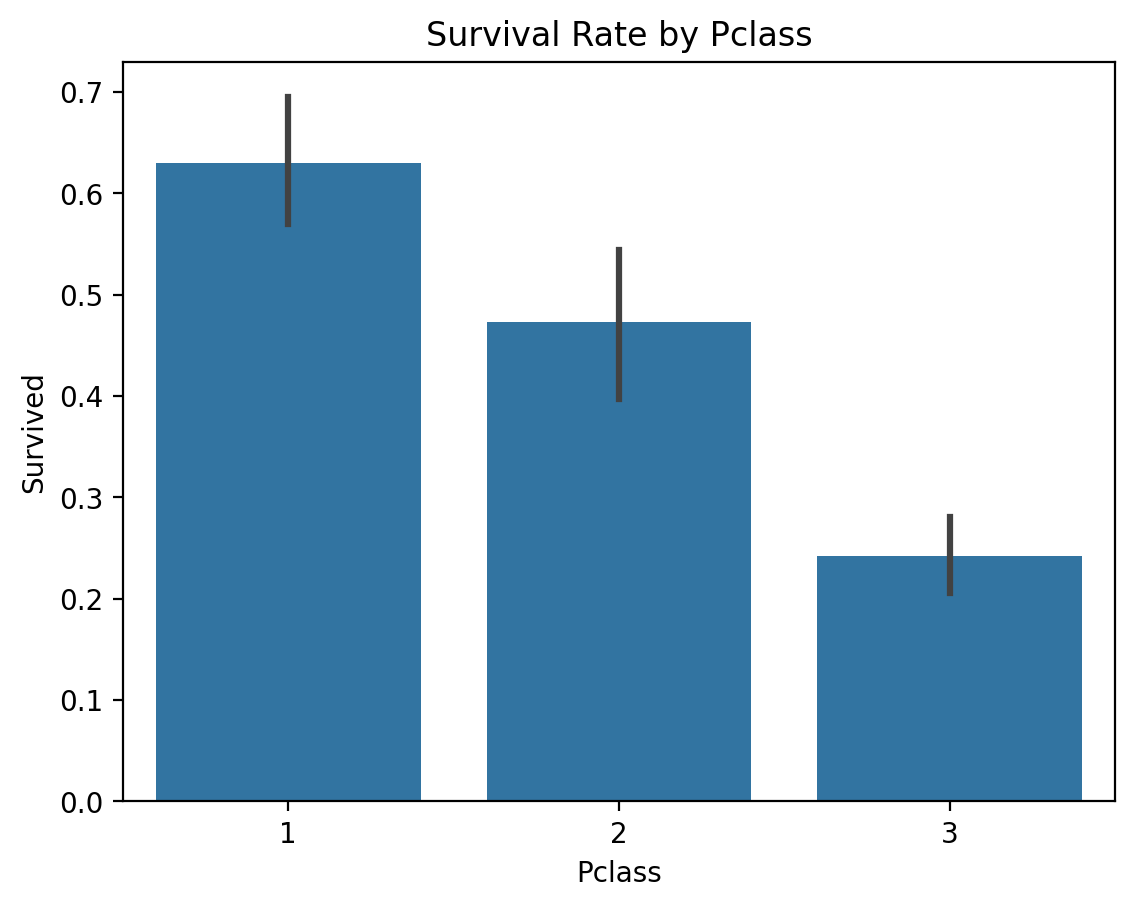

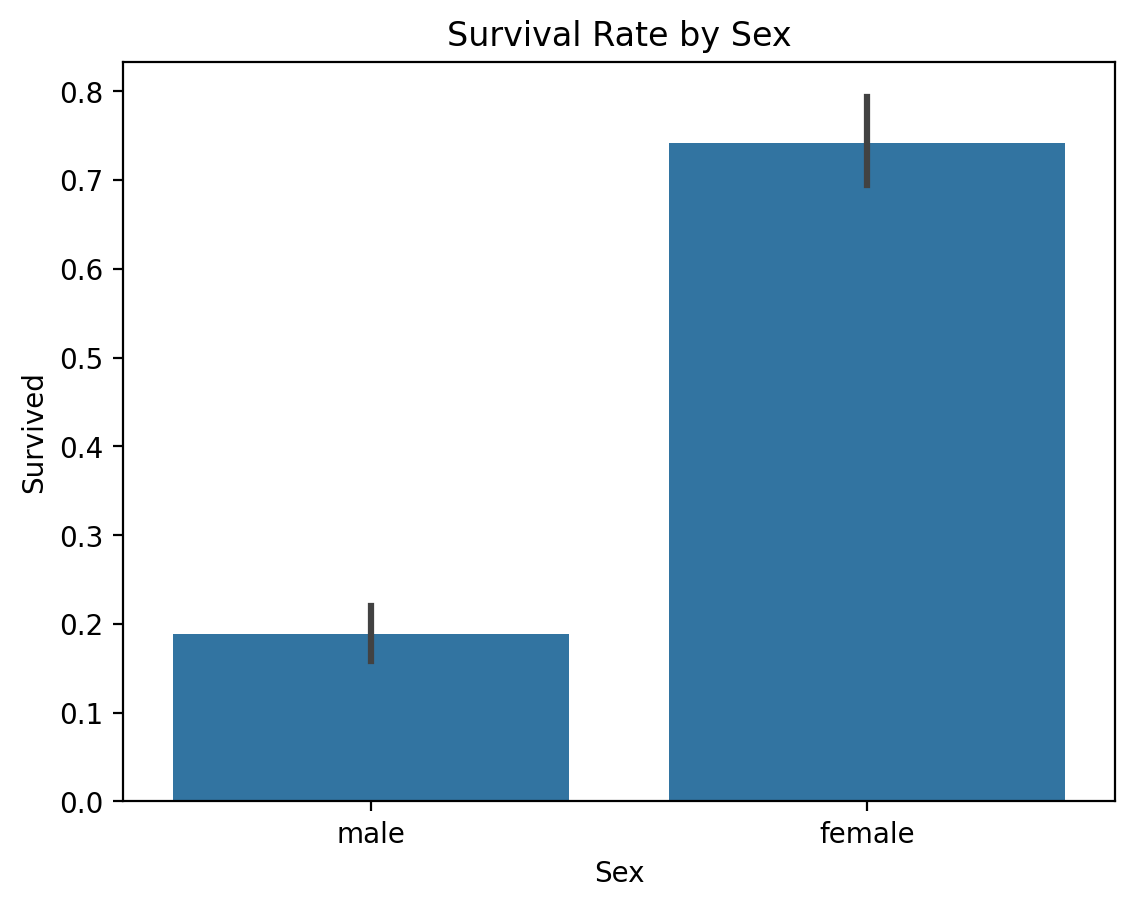

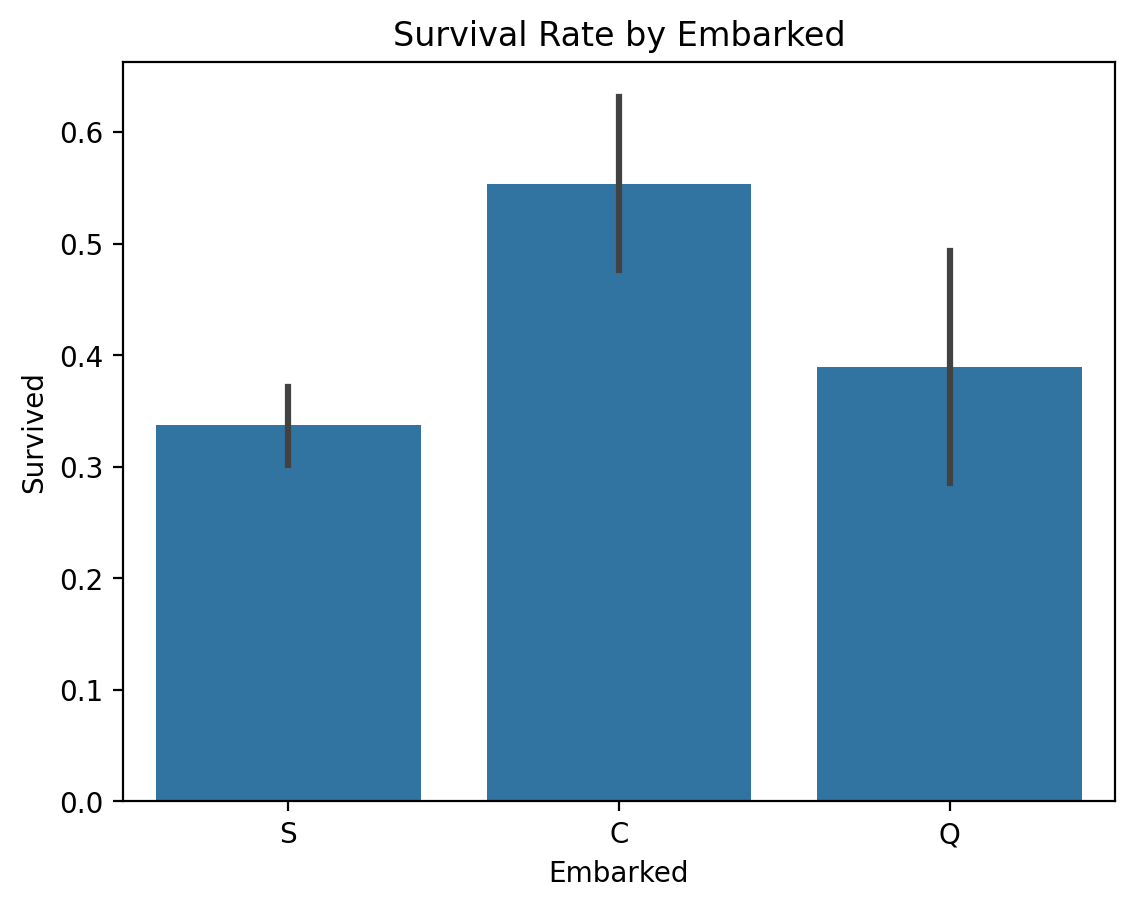

In [6]:
categorical_features = ['Pclass', 'Sex', 'Embarked']
for feature in categorical_features:
    sns.barplot(data=df, x=feature, y='Survived')
    plt.title(f'Survival Rate by {feature}')
    plt.show()

### Box Plots for Numerical Features Grouped by Categorical Features

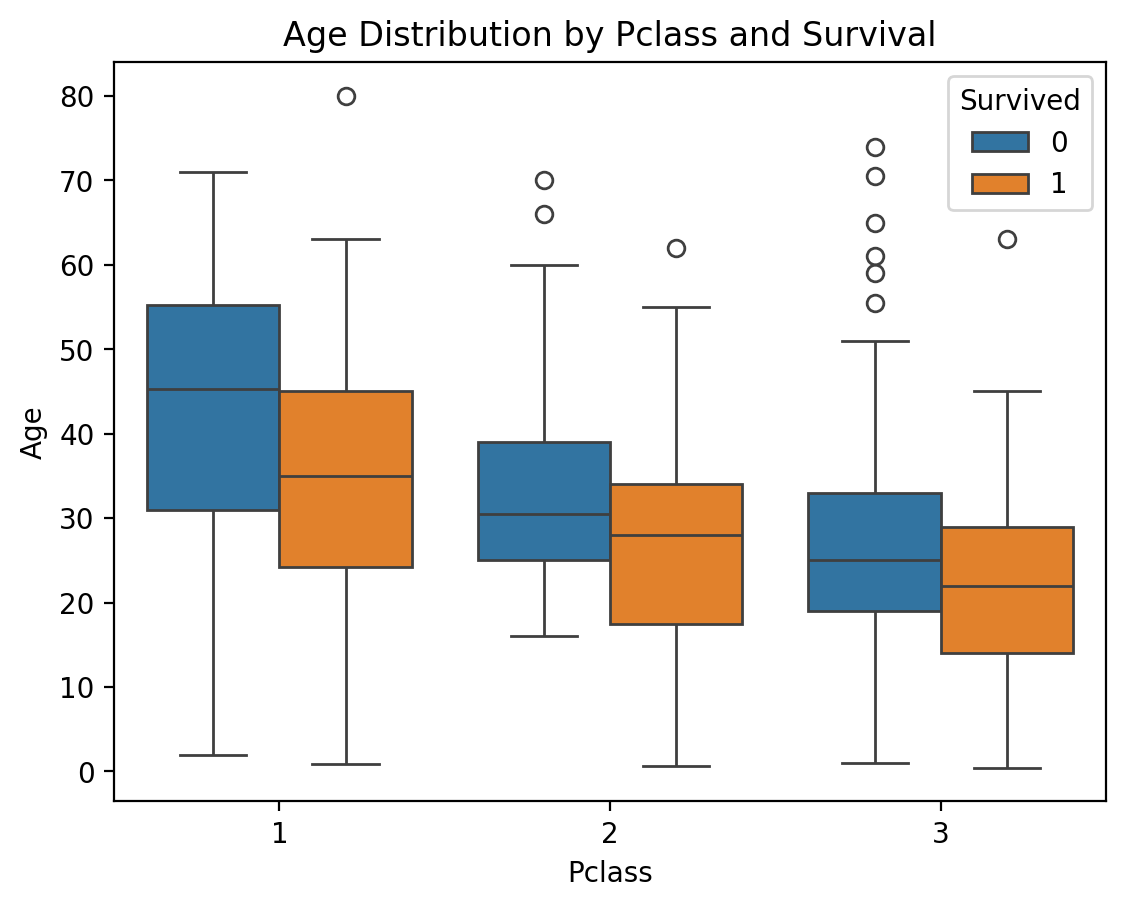

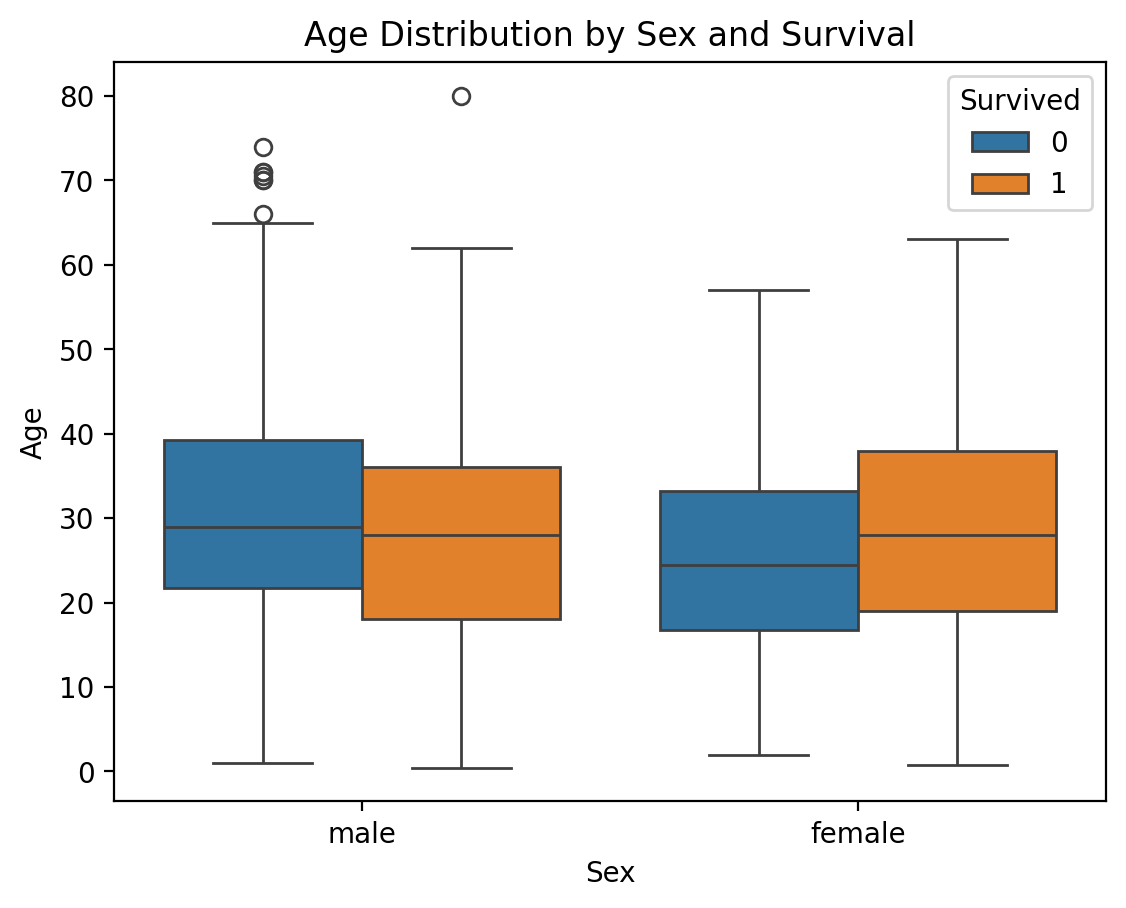

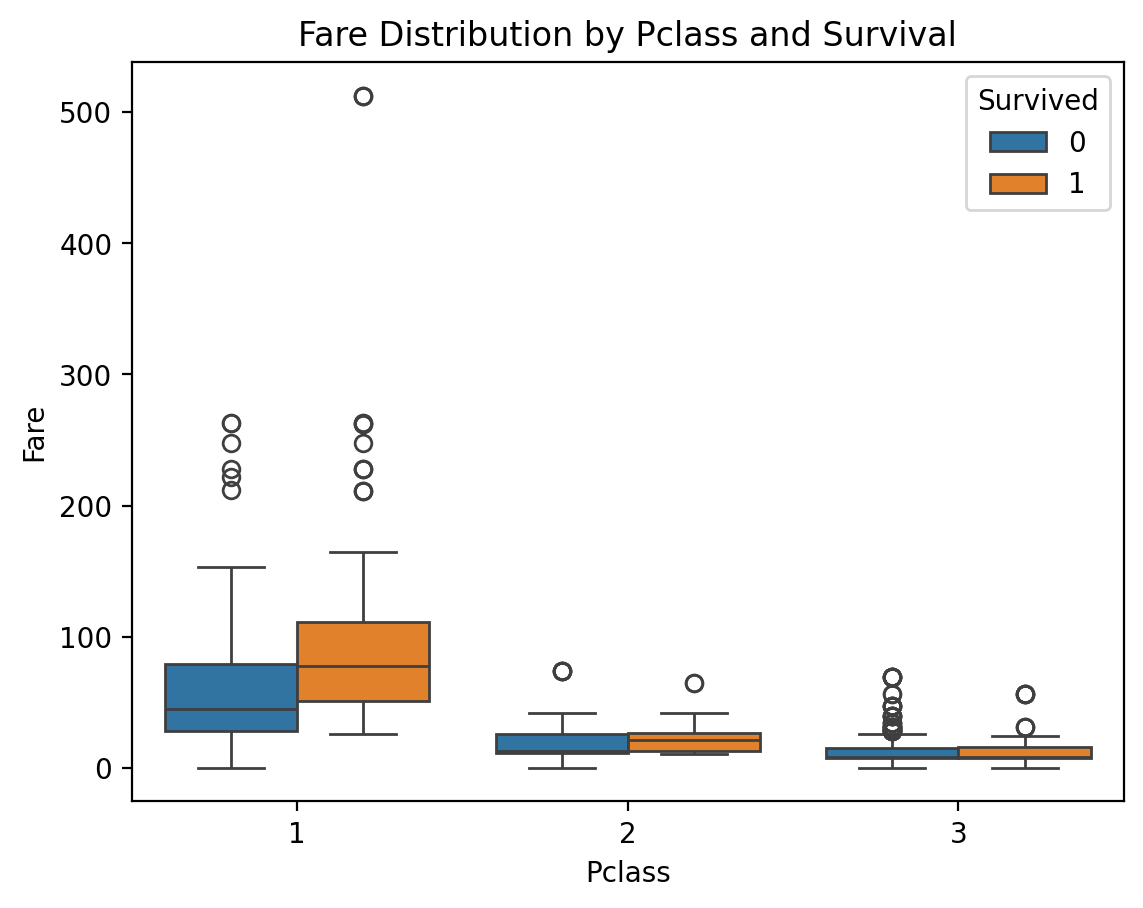

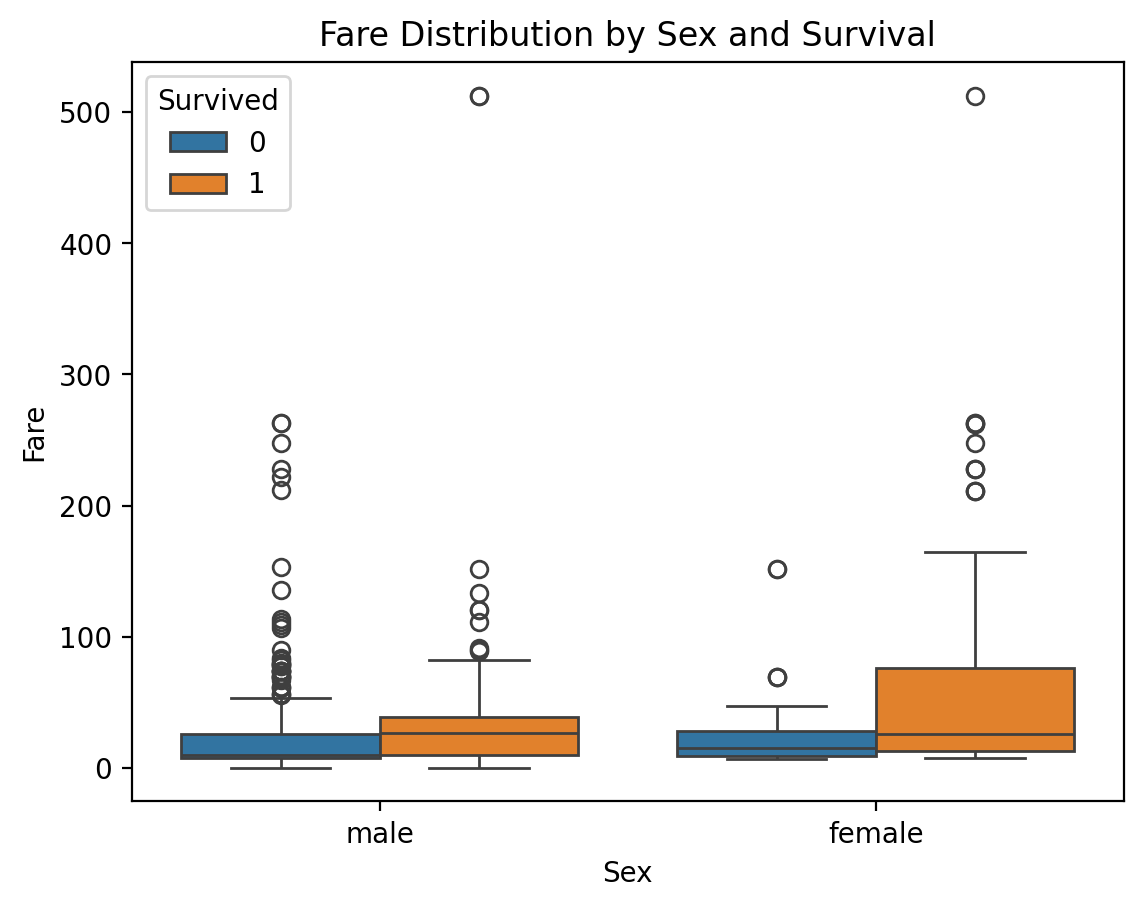

In [7]:
numerical_features = ['Age', 'Fare']
categorical_features = ['Pclass', 'Sex']
for num_feat in numerical_features:
    for cat_feat in categorical_features:
        sns.boxplot(data=df, x=cat_feat, y=num_feat, hue='Survived')
        plt.title(f'{num_feat} Distribution by {cat_feat} and Survival')
        plt.show()

### Pair Plots

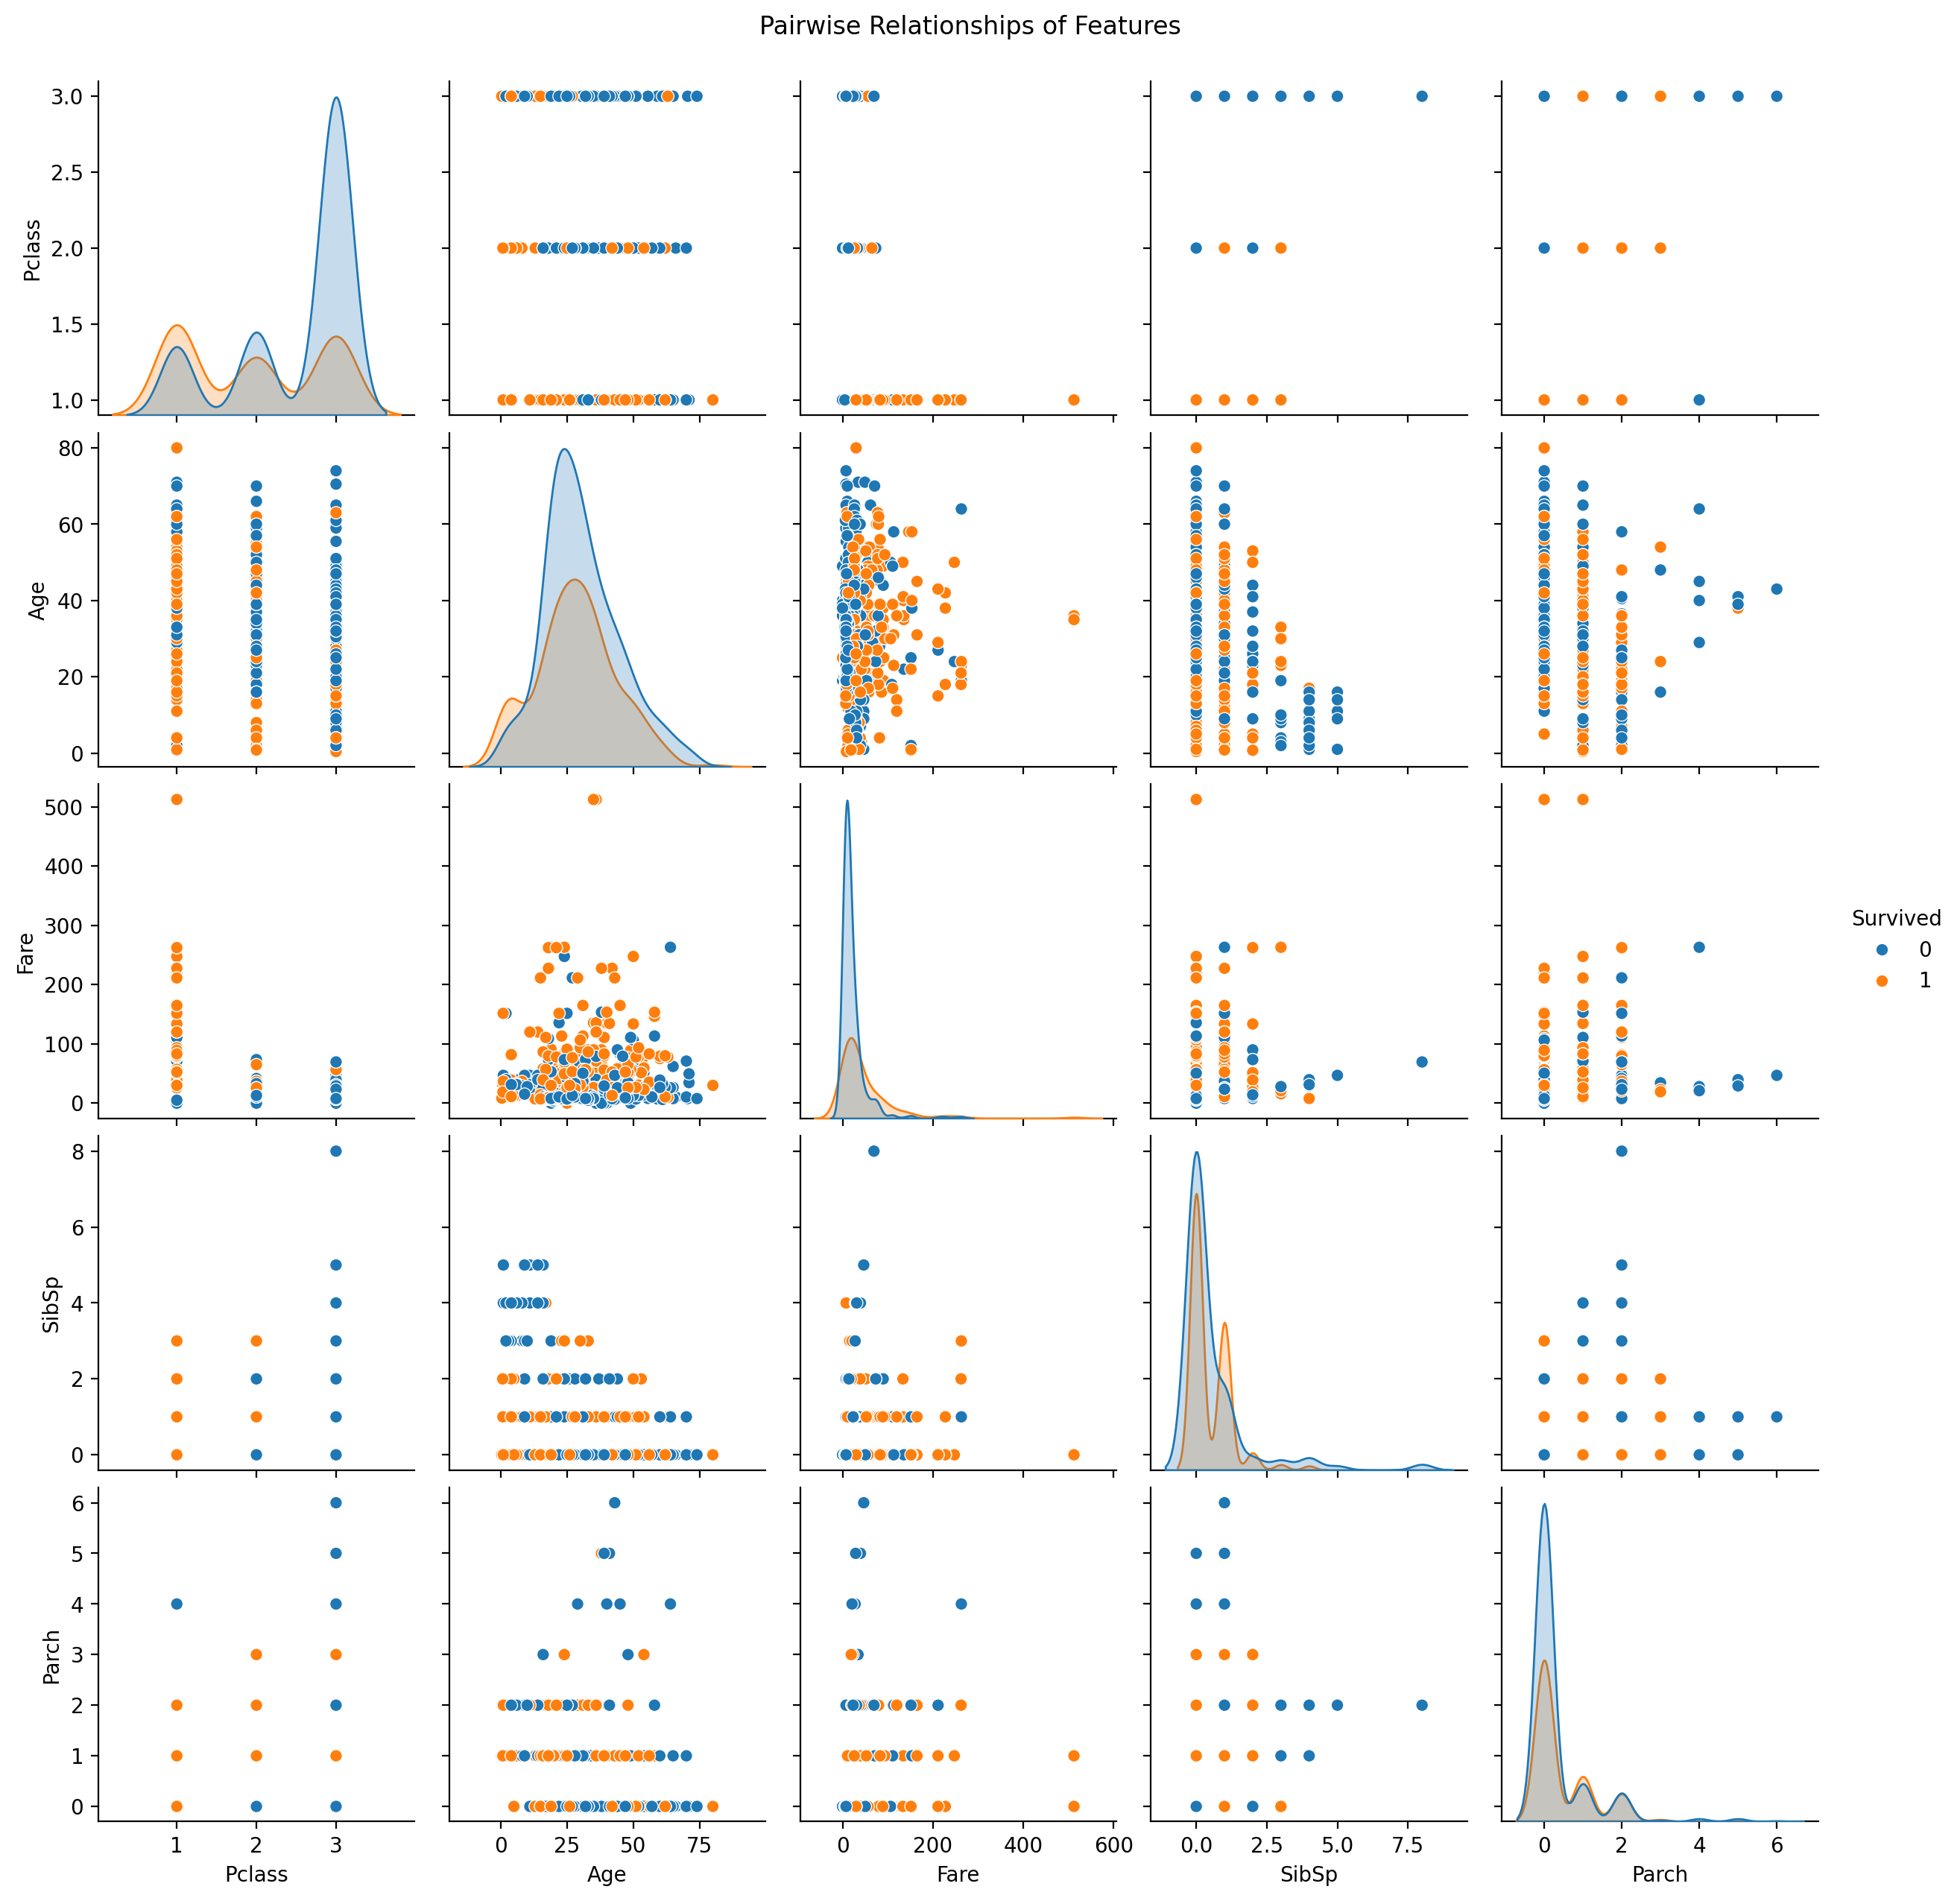

In [8]:
sns.pairplot(df[['Survived', 'Pclass', 'Age', 'Fare', 'SibSp', 'Parch']], hue='Survived')
plt.suptitle('Pairwise Relationships of Features', y=1.02)
plt.show()

### Correlation Heatmap

In [9]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

----
## Feature Engineering

### 1. Titles

Converting the names to their respective titles.

In [10]:
# Fetch all the unique titles from the dataset

all_titles = []

for name_string in df["Name"] :
    comma_pos = name_string.find(',')
    dot_pos = name_string.find('.')
    title = name_string[comma_pos + 2:dot_pos]
    if title not in all_titles :
        all_titles.append(title)

print(all_titles)

['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess', 'Jonkheer']


In [11]:
# Function to return the title for a given name
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    # print(big_string)
    return np.nan

In [12]:
# Evalute the above function to each row and add it as a column

df['Title']=df['Name'].map(lambda x: substrings_in_string(x, all_titles))
 
#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
df['Title']=df.apply(replace_titles, axis=1)
print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked Title  
0      0         A/5 21171   7.2500   NaN        S    Mr  
1      0          PC 17599  71.2833   C85        C    Mr  
2      0  STON/O2. 3101282   7.9250   NaN        S  Miss  
3      0            113803  53.1000  C123        S    Mr  
4      0            37345

### 2. Seperate Cabin and Deck information

In [13]:
# Turning cabin number into Deck
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Nan']

df['Deck']=df['Cabin'].map(lambda x: substrings_in_string(str(x), cabin_list))
print(df['Deck'].head())

0    NaN
1      C
2    NaN
3      C
4    NaN
Name: Deck, dtype: object


In [14]:
# Size of the Dataframe

df.shape

(891, 14)

### 3. Create new features
- Family Size
- Product of Age and Class
- Fare per person

In [15]:
# Creating new family_size column
df['Family_Size']=df['SibSp']+df['Parch']

# Since age and class are both numbers we can just multiply them.
df['Age*Class']=df['Age']*df['Pclass']

# Here we divide the fare by the number of family members traveling together, I’m not exactly sure what this represents, but it’s easy enough to add in.

df['Fare_Per_Person']=df['Fare']/(df['Family_Size']+1)


### 4. Dropping 4 features
- Passenger ID
- Name
- Ticket
- Deck : A lot of NaN values

In [16]:
# Dropping the columns

df = df.drop('PassengerId', axis=1)
df = df.drop('Name', axis=1)
df = df.drop('Ticket', axis=1)
df = df.drop('Deck', axis=1)

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Family_Size,Age*Class,Fare_Per_Person
0,0,3,male,22.0,1,0,7.2500,NaN,S,Mr,1,66.0,3.62500
1,1,1,female,38.0,1,0,71.2833,C85,C,Mr,1,38.0,35.64165
2,1,3,female,26.0,0,0,7.9250,NaN,S,Miss,0,78.0,7.92500
3,1,1,female,35.0,1,0,53.1000,C123,S,Mr,1,35.0,26.55000
4,0,3,male,35.0,0,0,8.0500,NaN,S,Mr,0,105.0,8.05000


### 5. Label encoding

In [17]:
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

In [18]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Family_Size,Age*Class,Fare_Per_Person
0,0,3,1,22.0,1,0,7.2500,147,2,2,1,66.0,3.62500
1,1,1,0,38.0,1,0,71.2833,81,0,2,1,38.0,35.64165
2,1,3,0,26.0,0,0,7.9250,147,2,1,0,78.0,7.92500
3,1,1,0,35.0,1,0,53.1000,55,2,2,1,35.0,26.55000
4,0,3,1,35.0,0,0,8.0500,147,2,2,0,105.0,8.05000


---

# Training

### Implement Decision Tree

In [19]:
X = df.iloc[:, 1:]
Y = df.iloc[:, 0]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
decisionTree = DecisionTreeClassifier()
decisionTree.fit(X_train, Y_train)

In [ ]:
Y_pred = decisionTree.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy}')

In [ ]:
importances = decisionTree.feature_importances_
features = X_train.columns

# Plot
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:15][::-1], importance_df['Importance'][:15][::-1])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances (Decision Tree)")
plt.tight_layout()
plt.show()

### Implementing XGBoost

In [20]:
X = df.iloc[:, 1:]
Y = df.iloc[:, 0]

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


C:\ProgramData\anaconda3\envs\aiml\Lib\site-packages\xgboost\callback.py:386: UserWarning: [00:07:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Best Hyperparameters: {'alpha': 0, 'colsample_bytree': 0.7, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'random_state': 42, 'subsample': 0.7}
Best Accuracy: 0.8490709677419355
Accuracy (best model): 0.8134
AUC (best model): 0.8820
Log Loss (best model): 0.4144


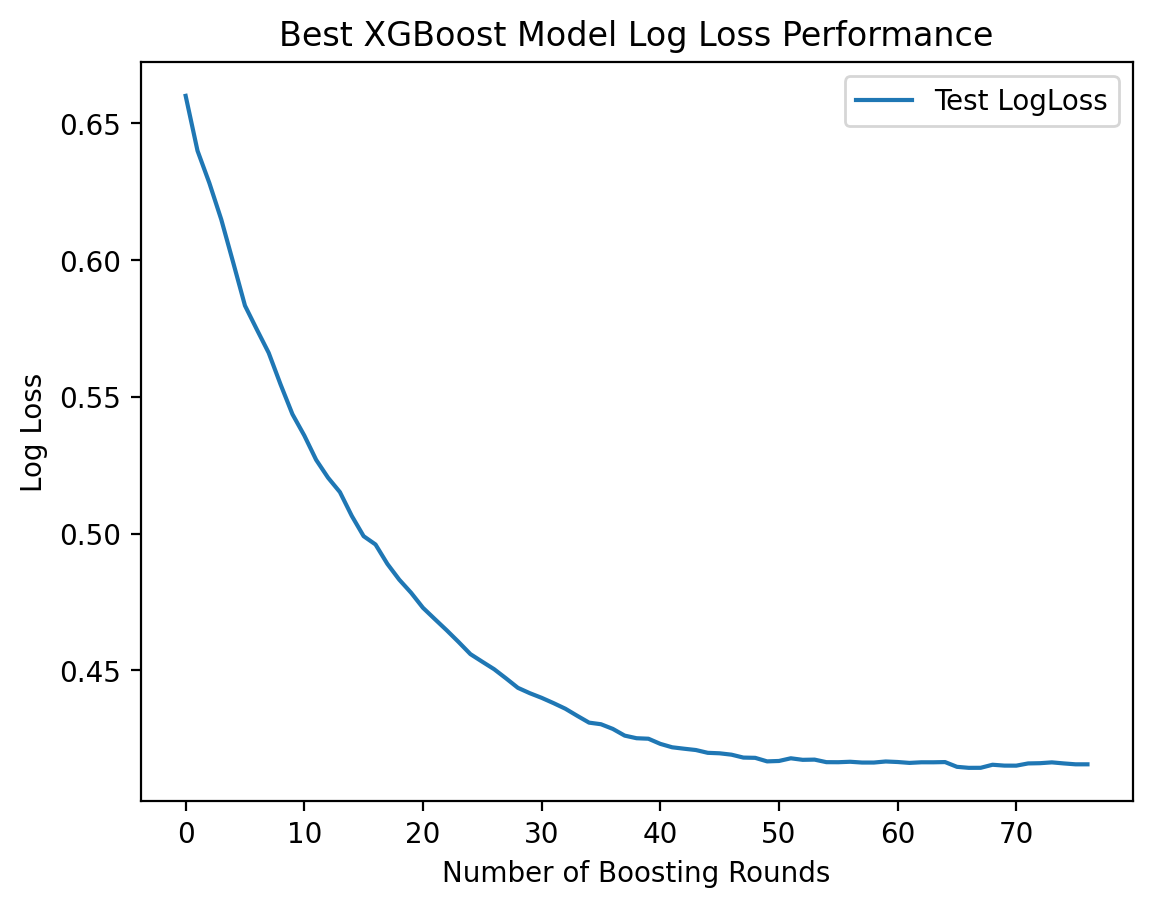

In [22]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'alpha': [0, 0.1, 0.5],  # L1 regularization strength
    'lambda': [1, 0.5, 0],   # L2 regularization strength
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'random_state': [42]
}

# Initialize XGBoost Classifier with early_stopping_rounds
# It's good practice to define it here, even if some versions allow it in fit()
xgboostClassifier = xgb.XGBClassifier(objective='binary:logistic',
                                     eval_metric='logloss',
                                     use_label_encoder=False,
                                     early_stopping_rounds=10)  # Corrected placement

# Set up StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgboostClassifier,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train, Y_train,
                  eval_set=[(X_test, Y_test)], # Pass eval_set to GridSearchCV
                  verbose=False) # Important: Suppress verbosity in GridSearch

# Print the best hyperparameters and the best score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

xgb_best_hyperparameters = grid_search.best_params_

# Get the best model from GridSearchCV
best_xgboost = grid_search.best_estimator_

# No need to fit again, it's already trained in GridSearchCV.
# Make predictions on the test set using the best model
Y_pred_proba = best_xgboost.predict_proba(X_test)[:, 1]
Y_pred_class = (Y_pred_proba > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(Y_test, Y_pred_class)
auc = roc_auc_score(Y_test, Y_pred_proba)
logloss = log_loss(Y_test, Y_pred_proba)

print(f"Accuracy (best model): {accuracy:.4f}")
print(f"AUC (best model): {auc:.4f}")
print(f"Log Loss (best model): {logloss:.4f}")

# Retrieve the evaluation results from the best model.  Access it from the grid_search
results = grid_search.best_estimator_.evals_result()

if 'validation_0' in results and 'logloss' in results['validation_0']:
    epochs = len(results['validation_0']['logloss'])
    x_axis = range(0, epochs)
    plt.figure()
    plt.plot(x_axis, results['validation_0']['logloss'], label='Test LogLoss')
    plt.legend()
    plt.xlabel('Number of Boosting Rounds')
    plt.ylabel('Log Loss')
    plt.title('Best XGBoost Model Log Loss Performance')
    plt.show()
else:
    print("Logloss not found in evals_result.  Check eval_metric.")

In [23]:
# xgboostClassifier = xgb.XGBClassifier(n_estimators=50, eval_metric='rmsle', early_stopping_rounds=10, random_state=42, learning_rate=0.05)

# # Train the model with early stopping
# xgboostClassifier.fit(X_train, Y_train, eval_set=[(X_test, Y_test)])

# # Retrieve the RMSLE values from the training process
# results = xgboostClassifier.evals_result()
# epochs = len(results['validation_0']['rmsle'])
# x_axis = range(0, epochs)

# # Plot the RMSLE values
# plt.figure()
# plt.plot(x_axis, results['validation_0']['rmsle'], label='Test')
# plt.legend()
# plt.xlabel('Number of Boosting Rounds')
# plt.ylabel('RMSLE')
# plt.title('XGBoost RMSLE Performance')
# plt.show()


In [24]:
# Y_pred = xgboostClassifier.predict(X_test)
# final_rmsle = np.sqrt(np.mean(np.square(np.log1p(Y_pred) - np.log1p(Y_test))))
# print(f"Final RMSLE on test set: {final_rmsle:.4f}")
# accuracy = accuracy_score(Y_test, Y_pred)
# print(f'Accuracy: {accuracy}')

<Figure size 1000x600 with 0 Axes>

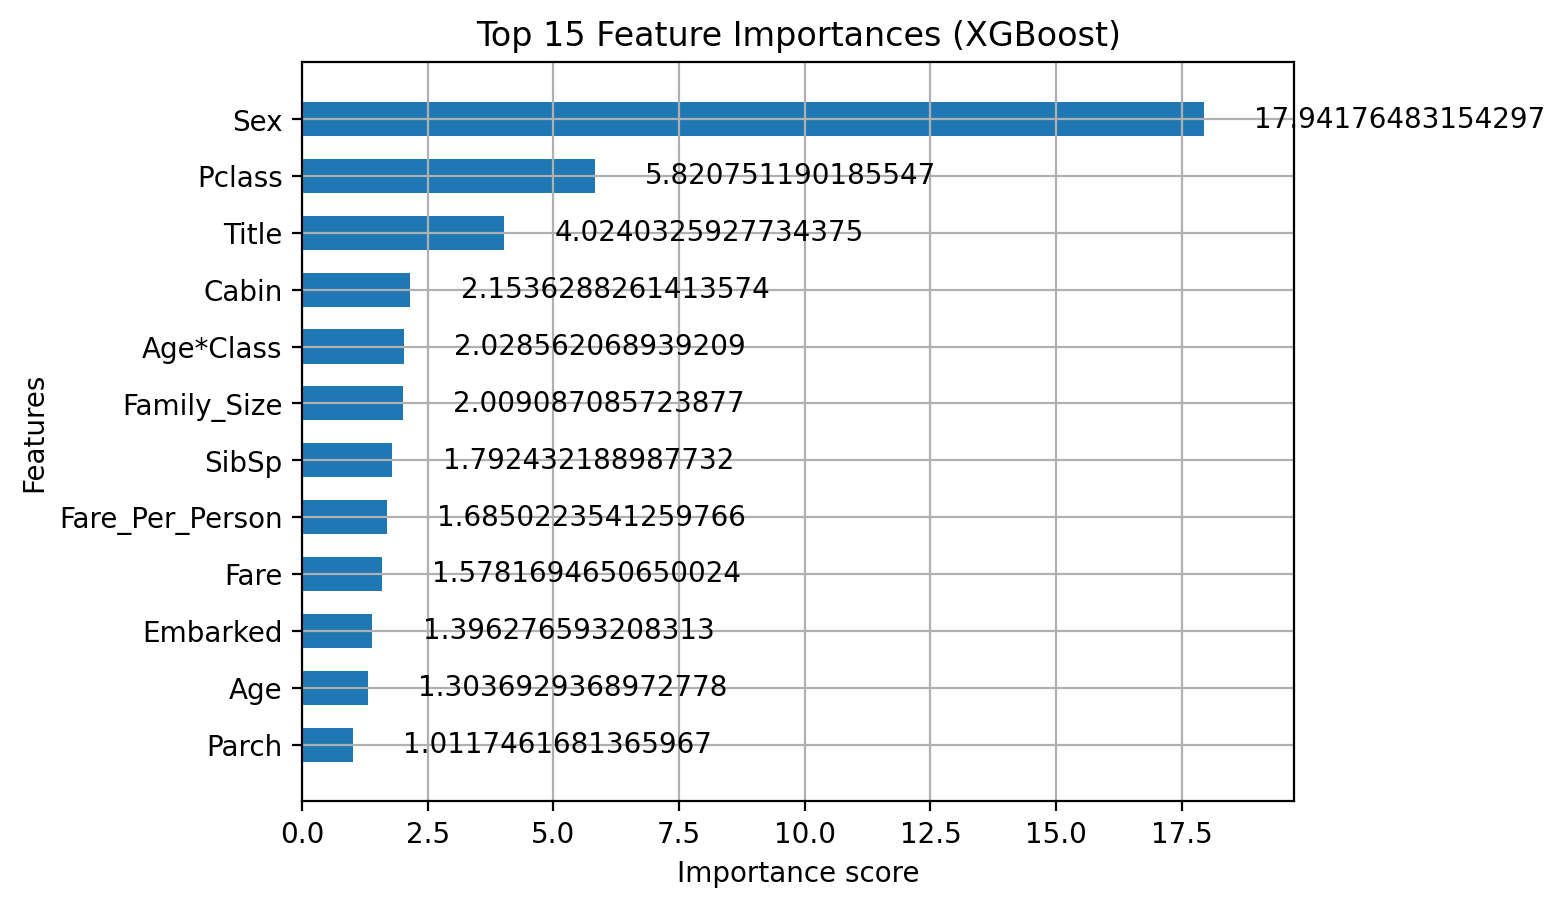

In [25]:
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_xgboost, importance_type='gain', max_num_features=15, height=0.6)
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()

In [ ]:
# feature_importance = best_xgboost.feature_importances_
# feature_names = X_train.columns # Assuming your X_train is a pandas DataFrame

# sorted_indices = np.argsort(feature_importance)[::-1]

# plt.figure(figsize=(10, 6))
# plt.title("Feature Importance (Best XGBoost Model)")
# plt.bar(range(X_train.shape[1]), feature_importance[sorted_indices], align="center")
# plt.xticks(range(X_train.shape[1]), feature_names[sorted_indices], rotation='vertical')
# plt.tight_layout()
# plt.show()

In [28]:
xgb_best_hyperparameters

{'alpha': 0,
 'colsample_bytree': 0.7,
 'lambda': 1,
 'learning_rate': 0.05,
 'max_depth': 7,
 'n_estimators': 100,
 'random_state': 42,
 'subsample': 0.7}

In [30]:
xgb_model_extra = xgb.XGBClassifier(
    alpha=0, 
    colsample_bytree=0.7, 
    reg_lambda=1,  # ✅ Replaced 'lambda' with 'reg_lambda'
    learning_rate=0.05, 
    max_depth=7, 
    n_estimators=100,  # ✅ Fixed comma
    random_state=42,  # ✅ Fixed comma
    subsample=0.7  # ✅ Fixed comma
)

# Fit model
xgb_model_extra.fit(X, Y)

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, ...)

## Removing NaN Values

In [ ]:
# Number of rows with NaN value

nan_counts = df.isna().sum()

for column, count in nan_counts.items():
    print(f"Column '{column}': {count} NaN values")

In [ ]:
# Handling the missing values

df['Age_Missing'] = df['Age'].isnull().astype(int)

def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]

    if pd.isnull(Age):
        if Pclass == 1:
            return df[df['Pclass'] == 1]['Age'].median()
        elif Pclass == 2:
            return df[df['Pclass'] == 2]['Age'].median()
        else:
            return df[df['Pclass'] == 3]['Age'].median()
    return Age

df['Age'] = df[['Age', 'Pclass']].apply(impute_age, axis=1)

print(f"Number of NaN values in Age after Pclass-based imputation: {df['Age'].isna().sum()}")

In [ ]:

df.dropna(subset=['Embarked'], inplace=True)

In [ ]:
df['Age*Class']=df['Age']*df['Pclass']

In [ ]:
# Number of rows with NaN value

nan_counts = df.isna().sum()

for column, count in nan_counts.items():
    print(f"Column '{column}': {count} NaN values")

### Learning Curve Function

In [ ]:
def plot_learning_curves(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, scoring='accuracy', cv=5, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, val_mean, 'o-', color='g', label='Cross-validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.show()

In [ ]:
def plot_roc_curve_rfe(rfe_model, X_test, y_test):
    """
    Plots the Receiver Operating Characteristic (ROC) curve for a trained RFE model
    with a Logistic Regression estimator.

    Args:
        rfe_model: Trained RFE object where the estimator is a classifier
                   with a 'predict_proba' method (e.g., LogisticRegression).
        X_test: Features of the test set.
        y_test: True labels of the test set.
    """
    # Check if the RFE object has a trained estimator
    if hasattr(rfe_model, 'estimator_') and hasattr(rfe_model.estimator_, "predict_proba"):
        # Use the underlying estimator's predict_proba method on the transformed test data
        X_test_transformed = rfe_model.transform(X_test)
        y_pred_proba = rfe_model.estimator_.predict_proba(X_test_transformed)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curve (with RFE)')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print("Error: The provided RFE model does not have a trained estimator with a 'predict_proba' method.")
        print("Ensure the RFE estimator is a classifier that outputs probabilities (e.g., LogisticRegression).")


### Implementing Logistic Regression

In [ ]:
X = df.iloc[:, 1:]
Y = df.iloc[:, 0]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
def plot_validation_curve_for_rfe(estimator, X, y, param_name, param_range, scoring='accuracy', cv=5):
    train_scores, val_scores = validation_curve(
        estimator, X, y, param_name=f'estimator__{param_name}', param_range=param_range, scoring=scoring, cv=cv
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.plot(param_range, train_mean, 'o-', color='r', label='Training score')
    plt.plot(param_range, val_mean, 'o-', color='g', label='Cross-validation score')
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
    plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.title(f'Validation Curve for C in Logistic Regression (with RFE)')
    plt.legend(loc='best')
    plt.xscale('log') # Since C is often explored on a log scale
    plt.show()
    
c_param_range = np.logspace(-4, 4, 9)

logisticRegression_full = LogisticRegression(max_iter=1000)
logisticRegression = RFE(logisticRegression_full, n_features_to_select=8)
plot_validation_curve_for_rfe(logisticRegression, X_train, Y_train, param_name='C', param_range=c_param_range)
logisticRegression.fit(X_train, Y_train)
selected_features = X_train.columns[logisticRegression.support_]

In [ ]:
Y_pred = logisticRegression.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
# print(f'Accuracy: {accuracy}')
print(classification_report(Y_test, Y_pred))

In [ ]:
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
coefficients = np.abs(logisticRegression.estimator_.coef_[0])
features = selected_features

importance_df = pd.DataFrame({'Feature': features, 'Importance': coefficients})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:15][::-1], importance_df['Importance'][:15][::-1])
plt.xlabel("Coefficient Magnitude")
plt.title("Top 15 Feature Importances (Logistic Regression)")
plt.tight_layout()
plt.show()

### Learning Curves (Accuracy vs. Training Size)

In [ ]:
plot_learning_curves(logisticRegression, X_train, Y_train)

In [ ]:
plot_roc_curve_rfe(logisticRegression, X_test, Y_test)

### Implementing Random Forest

In [ ]:
randomForest = RandomForestClassifier()
randomForest.fit(X_train, Y_train)

In [ ]:
Y_pred = randomForest.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy}')

In [ ]:
importances = randomForest.feature_importances_
features = X_train.columns

# Plot
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:15][::-1], importance_df['Importance'][:15][::-1])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances (Radnom Forest)")
plt.tight_layout()
plt.show()

### Implementing Decision Tree (without NaN)

In [ ]:
decisionTree_v2 = DecisionTreeClassifier()
decisionTree_v2.fit(X_train, Y_train)

In [ ]:
Y_pred = decisionTree_v2.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy}')

### Implementing XGBoost (without NaN)

In [ ]:
xgboostClassifier_2 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgboostClassifier_2.fit(X_train, Y_train)

In [ ]:
Y_pred = xgboostClassifier_2.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy}')

---------

# Titanic Dataset Test


### Import Test Dataset

In [32]:
df = pd.read_csv('Datasets/test.csv')
print(df.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  



## Feature Engineering

### 1. Titles

Converting the names to their respective titles.

In [33]:
# Fetch all the unique titles from the dataset

all_titles = []

for name_string in df["Name"] :
    comma_pos = name_string.find(',')
    dot_pos = name_string.find('.')
    title = name_string[comma_pos + 2:dot_pos]
    if title not in all_titles :
        all_titles.append(title)

print(all_titles)

['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona']


In [34]:
# Function to return the title for a given name
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    # print(big_string)
    return np.nan

In [35]:
# Evalute the above function to each row and add it as a column

df['Title']=df['Name'].map(lambda x: substrings_in_string(x, all_titles))
 
#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
df['Title']=df.apply(replace_titles, axis=1)
print(df.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked Title  
0  34.5      0      0   330911   7.8292   NaN        Q    Mr  
1  47.0      1      0   363272   7.0000   NaN        S    Mr  
2  62.0      0      0   240276   9.6875   NaN        Q    Mr  
3  27.0      0      0   315154   8.6625   NaN        S    Mr  
4  22.0      1      1  3101298  12.2875   NaN        S    Mr  


### 2. Seperate Cabin and Deck information

In [36]:
# Turning cabin number into Deck
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Nan']

df['Deck']=df['Cabin'].map(lambda x: substrings_in_string(str(x), cabin_list))
print(df['Deck'].head())

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: Deck, dtype: object


In [37]:
# Size of the Dataframe

df.shape

(418, 13)

### 3. Create new features
- Family Size
- Product of Age and Class
- Fare per person

In [38]:
# Creating new family_size column
df['Family_Size']=df['SibSp']+df['Parch']

# Since age and class are both numbers we can just multiply them.
df['Age*Class']=df['Age']*df['Pclass']

# Here we divide the fare by the number of family members traveling together, I’m not exactly sure what this represents, but it’s easy enough to add in.

df['Fare_Per_Person']=df['Fare']/(df['Family_Size']+1)


### 4. Dropping 4 features
- Passenger ID
- Name
- Ticket
- Deck : A lot of NaN values

In [39]:
# Dropping the columns
passenger_df = df['PassengerId']
df = df.drop('PassengerId', axis=1)
df = df.drop('Name', axis=1)
df = df.drop('Ticket', axis=1)
df = df.drop('Deck', axis=1)

df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Family_Size,Age*Class,Fare_Per_Person
0,3,male,34.5,0,0,7.8292,NaN,Q,Mr,0,103.5,7.829200
1,3,female,47.0,1,0,7.0000,NaN,S,Mr,1,141.0,3.500000
2,2,male,62.0,0,0,9.6875,NaN,Q,Mr,0,124.0,9.687500
3,3,male,27.0,0,0,8.6625,NaN,S,Mr,0,81.0,8.662500
4,3,female,22.0,1,1,12.2875,NaN,S,Mr,2,66.0,4.095833


### 5. Label encoding

In [40]:
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])
    
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Family_Size,Age*Class,Fare_Per_Person
0,3,1,34.5,0,0,7.8292,76,1,3,0,103.5,7.829200
1,3,0,47.0,1,0,7.0000,76,2,3,1,141.0,3.500000
2,2,1,62.0,0,0,9.6875,76,1,3,0,124.0,9.687500
3,3,1,27.0,0,0,8.6625,76,2,3,0,81.0,8.662500
4,3,0,22.0,1,1,12.2875,76,2,3,2,66.0,4.095833


-------

### Predicting using Decision Tree

In [ ]:
Prediction_DT = decisionTree.predict(df)

In [ ]:
Submission_DT = pd.DataFrame({
    'PassengerId': passenger_df,
    'Survived': Prediction_DT
})

In [ ]:
Submission_DT.to_csv('submission_decision_tree.csv', index=False)

### Predicting using XGBoost

In [ ]:
Prediction_XGB = best_xgboost.predict(df)

In [ ]:
Submission_XGB = pd.DataFrame({
    'PassengerId': passenger_df,
    'Survived': Prediction_XGB
})

In [ ]:
Submission_XGB.to_csv('submission_xgb_v3.csv', index=False)

In [41]:
Prediction_XGB_extra = xgb_model_extra.predict(df)

In [43]:
Submission_XGB_extra = pd.DataFrame({
    'PassengerId': passenger_df,
    'Survived': Prediction_XGB_extra
})

In [44]:
Submission_XGB_extra.to_csv('submission_xgb_v3_extra.csv', index=False)

## Removing NaN Values

In [ ]:
# Number of rows with NaN value

nan_counts = df.isna().sum()

for column, count in nan_counts.items():
    print(f"Column '{column}': {count} NaN values")

In [ ]:
# Handling the missing values

df['Age_Missing'] = df['Age'].isnull().astype(int)

def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]

    if pd.isnull(Age):
        if Pclass == 1:
            return df[df['Pclass'] == 1]['Age'].median()
        elif Pclass == 2:
            return df[df['Pclass'] == 2]['Age'].median()
        else:
            return df[df['Pclass'] == 3]['Age'].median()
    return Age

df['Age'] = df[['Age', 'Pclass']].apply(impute_age, axis=1)

print(f"Number of NaN values in Age after Pclass-based imputation: {df['Age'].isna().sum()}")

In [ ]:
df.dropna(subset=['Embarked'], inplace=True)

In [ ]:
df['Age*Class']=df['Age']*df['Pclass']

In [ ]:
def impute_row_mean(row):
    if row.isnull().any():  # Check if there's any NaN in the row
        nan_indices = row.index[row.isna()]
        non_nan_values = row.dropna()
        if not non_nan_values.empty and not nan_indices.empty:
            for nan_index in nan_indices:
                row[nan_index] = non_nan_values.mean()
    return row

df = df.apply(impute_row_mean, axis=1)

In [ ]:
# Number of rows with NaN value

nan_counts = df.isna().sum()

for column, count in nan_counts.items():
    print(f"Column '{column}': {count} NaN values")

df.head()

### Prediction using Logistic Regression

In [ ]:
Prediction_LR = logisticRegression.predict(df)

In [ ]:
Submission_LR = pd.DataFrame({
    'PassengerId': passenger_df,
    'Survived': Prediction_LR
})

In [ ]:
Submission_LR.to_csv('submission_logistic_regression.csv', index=False)

### Prediction using Random Forest

In [ ]:
Prediction_RF = randomForest.predict(df)

In [ ]:
Submission_RF = pd.DataFrame({
    'PassengerId': passenger_df,
    'Survived': Prediction_RF
})

In [ ]:
Submission_RF.to_csv('submission_random_forest.csv', index=False)

### Prediction using Decision Tree (after removing NaN)

In [ ]:
Prediction_DT_2 = decisionTree_v2.predict(df)

In [ ]:
Submission_DT_2 = pd.DataFrame({
    'PassengerId': passenger_df,
    'Survived': Prediction_DT_2
})

In [ ]:
Submission_DT_2.to_csv('submission_decision_tree_v2.csv', index=False)

### Prediction using XGBoost (after removing NaN)

In [ ]:
Prediction_XGB_2 = xgboostClassifier_2.predict(df)

In [ ]:
Submission_XGB_2 = pd.DataFrame({
    'PassengerId': passenger_df,
    'Survived': Prediction_XGB_2
})

In [ ]:
Submission_XGB_2.to_csv('submission_xgb_v2.csv', index=False)